In [1]:
import numpy as np
from numpy import pi as π
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import firedrake
from firedrake import Constant, inner, grad, div, as_vector, sym, as_vector, dx, ds, Mesh
import meshpy, meshpy.geometry, meshpy.triangle
import irksome
from irksome import Dt


import matplotlib.pyplot as plt

# Initial mesh

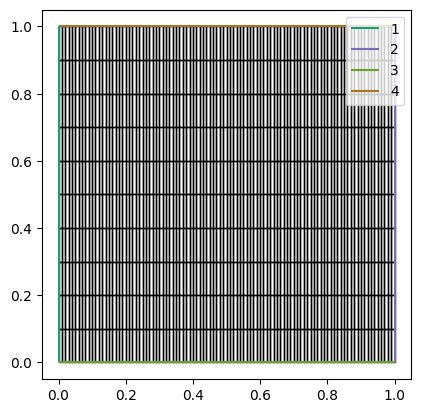

In [2]:
#Creating the initial mesh dimensions

nx, nz = 100, 10
initial_mesh = firedrake.UnitSquareMesh(nx, nz, quadrilateral=True)

fig, ax = plt.subplots()
ax.set_aspect("equal")
firedrake.triplot(initial_mesh, axes=ax)
ax.legend();

# Change the mesh coordinates to what domain we want

### One example mesh below

In [3]:
# # Replace this if necessary from other notebook

# xs = [Constant(x) for x in [0.0, 0.45, 0.55, 1.0, 1.0]]
# zs = [Constant(d) for d in [-150, -140, -110, -100, -100]]

# x, z = firedrake.SpatialCoordinate(initial_mesh)


# ξ_3 = (x - xs[2]) / (xs[3] - xs[2])
# expr3 = firedrake.conditional(
#     x <= xs[3],
#     zs[2] * (1 - ξ_3) + zs[3] * ξ_3,
#     -100,
# )

# ξ_2 = (x - xs[1]) / (xs[2] - xs[1])
# expr2 = firedrake.conditional(
#     x <= xs[2],
#     zs[1] * (1 - ξ_2) + zs[2] * ξ_2,
#     expr3,
# )

# ξ_1 = (x - xs[0]) / (xs[1] - xs[0])
# Z = firedrake.conditional(
#     x <= xs[1],
#     zs[0] * (1 - ξ_1) + zs[1] * ξ_1,
#     expr2,
# )

# Lx = Constant(40)
# z_b = Constant(0)
# expr = firedrake.as_vector([Lx * x, z * z_b + (1- z) * Z])

# Vc = initial_mesh.coordinates.function_space()
# X = firedrake.Function(Vc).interpolate(expr)
# mesh = firedrake.Mesh(X)

# fig, ax = plt.subplots()
# ax.set_aspect("auto")
# ax.set_xlabel("x (m)")
# ax.set_ylabel("z (m)")
# firedrake.triplot(mesh, axes=ax)
# ax.legend();

### Another example mesh

In [6]:


# xs = [Constant(x) for x in [0.0, 0.8, 1.0]]
# zs = [Constant(d) for d in [-depth, -depth, 0]]

# x, z = firedrake.SpatialCoordinate(initial_mesh)

# ξ_1 = (x - xs[1]) / (xs[2] - xs[1])
# expr1 = zs[1] * (1 - ξ_1)  + zs[2] * ξ_1

# ξ_2 = (x - xs[0]) / (xs[1] - xs[0])
# Z = firedrake.conditional(
#     x <= xs[1],
#     zs[0] * (1 - ξ_2) + zs[1] * ξ_2,
#     expr1)

# Lx = Constant(length)
# z_b = Constant(0)
# expr = firedrake.as_vector([Lx * x, z * z_b + (1- z) * Z])

# Vc = initial_mesh.coordinates.function_space()
# X = firedrake.Function(Vc).interpolate(expr)
# mesh = firedrake.Mesh(X)

# fig, ax = plt.subplots()
# ax.set_aspect("auto")
# ax.set_xlabel("x (m)")
# ax.set_ylabel("z (m)")
# firedrake.triplot(mesh, axes=ax)
# ax.legend();

### And another example mesh

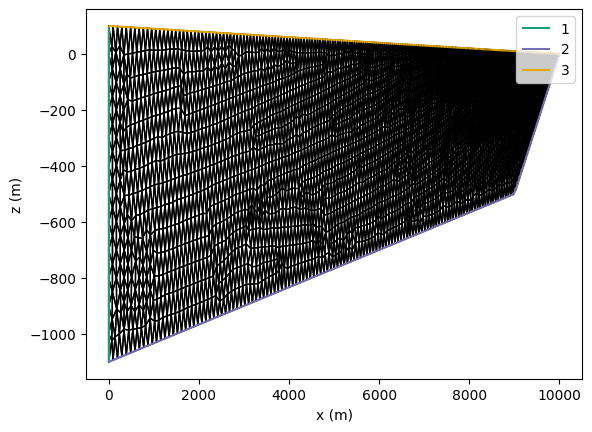

In [5]:
x, z = firedrake.SpatialCoordinate(initial_mesh)


depth = 500
length = 5000

mesh = Mesh('immersed_domain.msh')


fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
firedrake.triplot(mesh, axes=ax)
ax.legend();

# Modeling the initial conditions

In [7]:
# Constants
spy = 365.25 * 24 * 60 * 60
ρ = Constant(917.0)    # kg / m^3
c = Constant(2180)     # J / kg C
k = Constant(2.22)  # W / m C
α = (k/(ρ*c)) # diffusivity
A = 24e-25 
n = 3

dTdz = 2e-2 #C per 100m
geo_flux = Constant(46e-3) #W/m^2

λ = Constant(10.0)    # m
g = Constant(-9.81) #m/s^2

vel_mpy = Constant(0.50) #m/yr
vel = vel_mpy / spy

In [8]:
x, z = firedrake.SpatialCoordinate(mesh)

In [9]:
# Surface condition

surf_ids = [3]
T_mean = -31 #average temp (C)
T_surface = Constant(T_mean) #

In [10]:

element = firedrake.FiniteElement("CG", "triangle", 1)
V = firedrake.FunctionSpace(mesh, element)

T = firedrake.Function(V)
ϕ = firedrake.TestFunction(V)


geothermal_flux = -geo_flux*ϕ  * ds((2))

F = k * inner(grad(T), grad(ϕ)) * dx + geothermal_flux

surf_bc = firedrake.DirichletBC(V, T_surface, surf_ids)

bcs = [surf_bc]

firedrake.solve(F == 0, T, bcs)

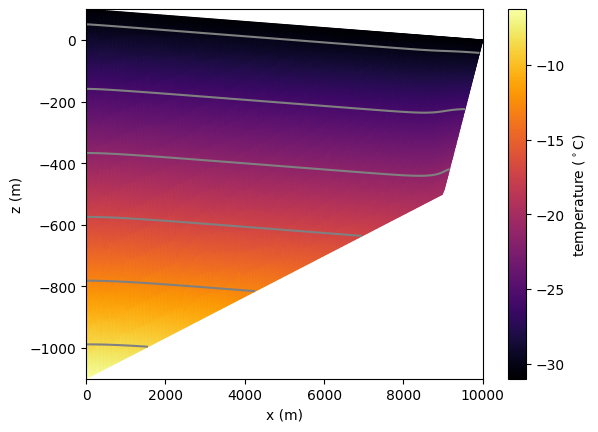

In [11]:
fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
colors = firedrake.tripcolor(T, cmap="inferno", axes=ax)
fig.colorbar(colors, label="temperature (${}^\circ$C)")
levels = np.linspace(-30, 0, 8)
firedrake.tricontour(T, levels=levels, colors="grey", axes=ax)
# ax.set_xlim([9000,10000]);

# Variational form

$$\int_\Omega \rho c (T-T_n) \cdot \phi + \delta t \cdot \frac{k}{\rho c} \nabla T \cdot \nabla \phi - \rho c uT \cdot \nabla \phi- \rho cwT \cdot \nabla \phi + \frac{2}{\rho c} \dot{\epsilon}_{xz}\tau_{xz}\cdot\phi \: \mathrm{d}x + \int_{\Gamma} \frac{k}{\rho c}\nabla T * n\phi \: \mathrm{d}\gamma$$

# Building the model

In [12]:
# element = firedrake.FiniteElement("CG", "quadrilateral", 1)
# V = firedrake.FunctionSpace(mesh, element)

# T = firedrake.Function(V)
# ϕ = firedrake.TestFunction(V)


In [13]:
pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 2)
Y = velocity_space * pressure_space

y = firedrake.Function(Y)
u, p = firedrake.split(y)


μ = Constant(1e14)
def ε(u):
    return sym(grad(u))

v, q = firedrake.TestFunctions(y.function_space())

τ = 2 * μ * ε(u)
g = as_vector((0, g))
f =  ρ * g

F_momentum = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx


In [14]:
# bc_b = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0)), [3]) 
# bc_l = firedrake.DirichletBC(Y.sub(0), as_vector((vel, 0)), [1]) 
# bc=[bc_b,bc_l]

In [23]:
velocity_profile = vel * (1-((z/depth))**(n+1))
velocity_profile = vel * (1-((z/depth))**(n+1))

bc_b = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0)), [2]) 

# bc_l = firedrake.DirichletBC(Y.sub(0), as_vector((velocity_profile, 0)), [1]) 
bc_l = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0)), [1]) 
bc=[bc_l, bc_b]
# bc=[bc_b]
# bc=[bc_l]

In [24]:
basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
nullspace = firedrake.MixedVectorSpaceBasis(Y, [Y.sub(0), basis])

In [25]:
stokes_problem = firedrake.NonlinearVariationalProblem(F_momentum, y, bc)
parameters = {
    "nullspace": nullspace,
    "solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)

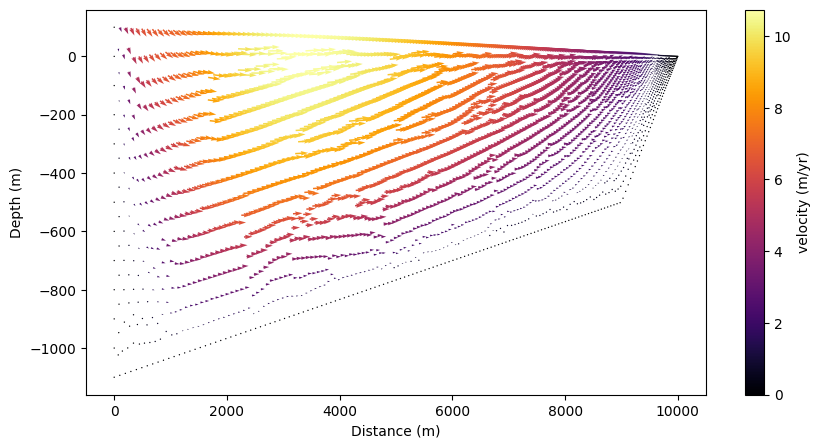

In [26]:
stokes_solver.solve()
fig, axes = plt.subplots(figsize = [10,5])
vel_field_plot = firedrake.quiver(y.sub(0)*spy, axes=axes, cmap="inferno");
fig.colorbar(vel_field_plot, label='velocity (m/yr)')
axes.set_ylabel('Depth (m)')
axes.set_xlabel('Distance (m)')
# axes.set_xlim([9000,10000])
plt.show()
fig.savefig('Test_model_flowfield.png')

# Stop here and choose which Function to use!

# Make the time stepper

In [28]:
import irksome
from irksome import Dt

δx = mesh.cell_sizes.dat.data_ro[:].min()
umax = y.sub(0).dat.data_ro[:].max()
δt = Constant(spy/2)


F_diffusion = k*inner(grad(T), grad(ϕ)) * dx
F_advection = - ρ * c * T * inner(u, grad(ϕ)) * dx
# F_shear_heating = strain_rate * ϕ * z * dx

# F = ρ * c * Dt(T) * ϕ * dx + F_advection + F_diffusion + geothermal_flux + F_shear_heating
F = ρ * c * Dt(T) * ϕ * dx + F_advection + F_diffusion + geothermal_flux 


# upper_bc = firedrake.DirichletBC(V, T_surface, [4])
# left_bc = firedrake.DirichletBC(V, -20, [1])
# bcs = [upper_bc, left_bc]

upper_bc = firedrake.DirichletBC(V, T_surface, [3])
left_bc = firedrake.DirichletBC(V, T_surface + ((z/depth)*0.024), [1])
bcs = [left_bc, upper_bc]

method = irksome.BackwardEuler()
temperature_solver = irksome.TimeStepper(F, method, Constant(0.0), δt, T, bcs=bcs)

# Find the initial condition

### We don't need to make an initial condition

In [29]:
# z_test = np.linspace(0,500,10)
# T_left = (-28.0 * (1 - z_test / 500) + -31.0 * z_test / 500)
# T_left

In [30]:
# T_left = (-28.0 * (1 - z / depth) + -31.0 * z / depth)

In [31]:
F_0 = F_advection + F_diffusion + geothermal_flux
# F_0 = F_advection + F_diffusion 

upper_bc_init = firedrake.DirichletBC(V, -31, [3])
left_bc_init = firedrake.DirichletBC(V, T_surface + ((z/depth)*0.024), [1])
bcs_init = [upper_bc_init, left_bc_init]

# upper_bc_init = firedrake.DirichletBC(V, -31, [4])
# bcs_init = [upper_bc_init]

firedrake.solve(F_0 == 0, T, bcs_init)

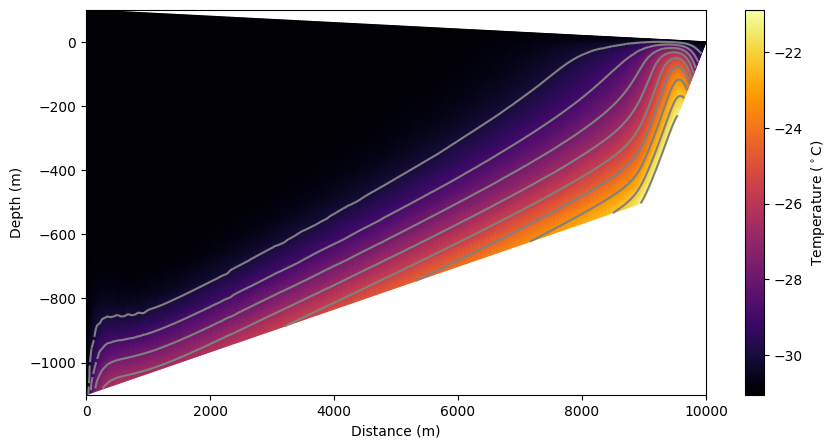

In [35]:
fig, ax = plt.subplots(figsize=[10,5])
ax.set_aspect("auto")
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Depth (m)")
colors = firedrake.tripcolor(T, cmap="inferno", axes=ax)
fig.colorbar(colors, label="Temperature (${}^\circ$C)")
levels = np.linspace(-30, -20, 10)
firedrake.tricontour(T, levels=levels, colors="grey", axes=ax);
fig.savefig('Test_model_temperature.png')

# Surface temperature to model

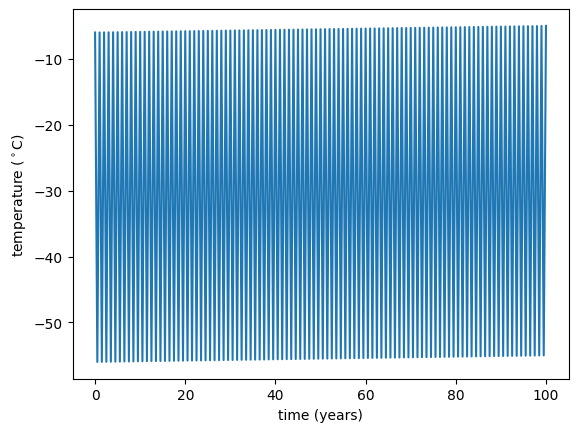

In [37]:
δT = 25.0
θ = 1 * π / 2
year = spy
years = 100
final_time = years * spy # years modeling * spy

freq = 1 # 1 for annual cycle
num_steps = int(final_time / float(δt))

def surface_temperature(t):
    return T_mean + δT * np.sin(2 * π *freq* t / year + θ) + (t/final_time)*1


ts = np.linspace(0.0, final_time, num_steps + 1)

surface_temps = surface_temperature(ts)

fig, ax = plt.subplots()
ax.set_xlabel("time (years)")
ax.set_ylabel("temperature (${}^\circ$C)")
ax.plot(ts / spy, surface_temps);

# Run the simulation

In [38]:
import tqdm
final_time = years* spy 
num_steps = int(final_time / float(δt))
Ts = [T.copy(deepcopy=True)]
ys = [y.copy(deepcopy=True)]

for step in tqdm.trange(num_steps):
    t = ts[step]
    T_surface.assign(surface_temperature(t))

    temperature_solver.advance()
    stokes_solver.solve()

    Ts.append(T.copy(deepcopy=True))
    ys.append(y.copy(deepcopy=True))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.42it/s]


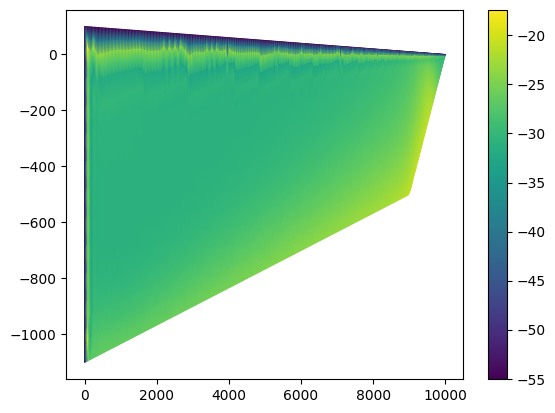

In [39]:
# Check final condition for accuracy
fig, ax = plt.subplots()
temp_field_end = firedrake.tripcolor(Ts[-1], axes=ax);
fig.colorbar(temp_field_end)

In [42]:

%%capture

def subplots():
    fig, axes = plt.subplots(figsize=[20,5])
    axes.set_aspect("auto")
    axes.get_xaxis().set_visible(True)
    axes.get_yaxis().set_visible(True)
    return fig, axes

fig, axes = subplots()
colors = firedrake.tripcolor(
    Ts[0], num_sample_points=4, vmin=-30, vmax=-10, cmap="viridis", axes=axes
)
# axes.set_xlim([9000,10000])
# axes.set_ylim([-300,10])
fig.colorbar(colors)

In [43]:
from matplotlib.animation import FuncAnimation
fn_plotter = firedrake.FunctionPlotter(mesh, num_sample_points=4)
def animate(T):
    colors.set_array(fn_plotter(T))

animation = FuncAnimation(fig, animate, frames=Ts, interval=1e4/24)

from IPython.display import HTML
HTML(animation.to_html5_video())

# _______________________________________________________________________________

# Trying a different way

## Maybe dont do this way

In [ ]:
import irksome
from irksome import Dt

δx = mesh.cell_sizes.dat.data_ro[:].min()
umax = y.sub(0).dat.data_ro[:].max()
δt = Constant(spy/12)


F_diffusion = k*inner(grad(T), grad(ϕ)) * dx
F_advection = - ρ * c * T * inner(u, grad(ϕ)) * dx

T_n = firedrake.Function(V)

F = ρ * c * (T-T_n) * ϕ * dx + F_advection + F_diffusion + geothermal_flux


upper_bc = firedrake.DirichletBC(V, T_surface, [4])
bcs = [upper_bc]

method = irksome.BackwardEuler()
temperature_solver = irksome.TimeStepper(F, method, Constant(0.0), δt, T, bcs=bcs)

In [ ]:
δT = 25.0
θ = 1 * π / 2
year = spy
years = 4
final_time = years * spy # years modeling * spy

freq = 1 # 1 for annual cycle
num_steps = int(final_time / float(δt))

def surface_temperature(t):
    return T_surface + δT * np.sin(2 * π *freq* t / year + θ)


ts = np.linspace(0.0, final_time, num_steps + 1)

# surface_temps = surface_temperature(ts)

# fig, ax = plt.subplots()
# ax.set_xlabel("time (years)")
# ax.set_ylabel("temperature (${}^\circ$C)")
# ax.plot(ts / spy, surface_temps);

In [ ]:
F_0 = F_advection + F_diffusion + geothermal_flux
#F_0 = F_diffusion + geothermal_flux

upper_bc_init = firedrake.DirichletBC(V, -31, [4])
bcs_init = [upper_bc_init]
firedrake.solve(F_0 == 0, T, bcs_init)

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
colors = firedrake.tripcolor(T, cmap="inferno", axes=ax)
fig.colorbar(colors, label="temperature (${}^\circ$C)")
levels = np.linspace(-30, 0, 10)
firedrake.tricontour(T, levels=levels, colors="grey", axes=ax);

In [ ]:
T_n.assign(T)

In [ ]:
import tqdm
final_time = years* spy 
num_steps = int(final_time / float(δt))
Ts = [T.copy(deepcopy=True)]
ys = [y.copy(deepcopy=True)]

for step in tqdm.trange(num_steps):

    T_surface.assign(surface_temperature(step))
    print(surface_temperature(step))
    print(T_surface)
    temperature_solver.advance()
    stokes_solver.solve()
    T_n.assign(T)
    Ts.append(T.copy(deepcopy=True))
    ys.append(y.copy(deepcopy=True))

In [ ]:
# Check final condition for accuracy
fig, ax = plt.subplots()
temp_field_end = firedrake.tripcolor(Ts[-1], axes=ax);
fig.colorbar(temp_field_end)

In [ ]:
%%capture

def subplots():
    fig, axes = plt.subplots(figsize=[10,10])
    axes.set_aspect("equal")
    axes.get_xaxis().set_visible(True)
    axes.get_yaxis().set_visible(True)
    return fig, axes

fig, axes = subplots()
colors = firedrake.tripcolor(
    Ts[0], num_sample_points=4, vmin=-30, vmax=0, cmap="inferno", axes=axes
)
fig.colorbar(colors)

In [ ]:
from matplotlib.animation import FuncAnimation
fn_plotter = firedrake.FunctionPlotter(mesh, num_sample_points=4)
def animate(T):
    colors.set_array(fn_plotter(T))

animation = FuncAnimation(fig, animate, frames=Ts, interval=1e3/24)

from IPython.display import HTML
HTML(animation.to_html5_video())